# 1.1 Load BTC-EUR price data

In [1]:
# IMPORTS FOR SCRIPT
import pandas as pd
import numpy as np
import calendar
import datetime
import math 
import matplotlib.pyplot as plt
%matplotlib inline
pd.options.mode.chained_assignment = None

pd.set_option('max_rows', None)  #if required to see all results

In [2]:
# Import price dataframes - note use prepare_trade_data.py on coinbase_BTC_EUR.csv prior to running this notebook
df = pd.read_csv('btc_eur_ohlc_4h.csv')
df_1d = pd.read_csv('btc_eur_ohlc_1d.csv')

# Convert date in 'Timestamp' column from strftime to datetime
df['Timestamp'] = pd.to_datetime(df['Timestamp'], format="%Y/%m/%d %H:%M")
df_1d['Timestamp'] = pd.to_datetime(df_1d['Timestamp'], format="%Y/%m/%d %H:%M")

In [3]:
# Specify cut-off point for data
year_start = 2016
year_end = 2018
# 4h
#df = df.loc[df['Timestamp'].dt.year >= years_selected,:]
df = df.loc[(df['Timestamp'].dt.year >= year_start)&(df['Timestamp'].dt.year <= year_end),:]
df_reset = df

# 1 Day
df_1d = df_1d.loc[(df_1d['Timestamp'].dt.year >= year_start)&(df_1d['Timestamp'].dt.year <= year_end),:]
df_1d_reset = df_1d

In [4]:
df.head()

,Timestamp,open,high,low,close,Volume_BTC
1481,2016-01-01 00:00:00,397.50,398.00,396.27,398.00,3.980000
1482,2016-01-01 04:00:00,398.00,402.00,397.81,401.08,31.568617
1483,2016-01-01 08:00:00,400.74,403.00,398.79,399.27,47.451098
1484,2016-01-01 12:00:00,399.43,399.63,394.84,399.50,54.199928
1485,2016-01-01 16:00:00,399.24,399.83,397.74,398.26,80.705204


<b> PLOT OHLC

In [5]:

# Import and use plotly
plotly_api_key = "bMumUdY9ofTF0daniz6v"
import plotly
plotly.tools.set_credentials_file(username='tyronehunt', api_key=plotly_api_key)
import plotly.plotly as py
import plotly.graph_objs as go

trace = go.Ohlc(x=df.Timestamp,
                open=df.open,
                high=df.high,
                low=df.low,
                close=df.close)
data = [trace]

layout = {
    'title': 'Bitcoin',
    'yaxis': {'title': 'Price - Euro'},


    'shapes': [{
        'type': 'line',
        'x0': '',
        'x1': '',
        'y0': '',
        'y1': '',
        'xref': 'x',
        'yref': 'paper',
        'line': {
            'color': 'rgb(30,30,30)',
            'width': 1
        }
        
    }],
    'annotations': [{
        'x': '2018-01-09', 'y': 0.05, 'xref': 'x', 'yref': 'paper',
        'showarrow': False, 'xanchor': 'left',
        'text': ''
    }]
}
fig = dict(data=data, layout=layout)
py.iplot(fig, filename='aapl-recession-ohlc')

#py.iplot(data, filename='simple_ohlc')"""

# 1.2 Calculate indicator raw data

In [5]:
import talib

def get_indicators(df):
    # Bollinger Bands
    bbupper, bbmiddle, bblower = talib.BBANDS(df['close']);
    bbwidth=bbupper - bblower;

    # MACD-12-26-9
    macd, macdsignal, macdhist = talib.MACD(df['close'], fastperiod=12, slowperiod=26, signalperiod=9);

    # RSI - 14
    rsi = talib.RSI(df['close'], timeperiod=14);

    # Exponential Moving Averages (20 periods and 50 periods [4h])
    ema20 = talib.EMA(df['close'], timeperiod=20);
    ema50 = talib.EMA(df['close'], timeperiod=50);

    # Candestick identifiers
    morning_doji_star = talib.CDLMORNINGDOJISTAR(df['open'], df['high'], df['low'], df['close'], penetration=0)/100
    morning_star = talib.CDLMORNINGSTAR(df['open'], df['high'], df['low'], df['close'], penetration=0)/100
    three_inside = talib.CDL3INSIDE(df['open'], df['high'], df['low'], df['close'])/100
    three_outside = talib.CDL3OUTSIDE(df['open'], df['high'], df['low'], df['close'])/100
    candles = pd.concat([morning_doji_star,morning_star,three_inside,three_outside], axis=1)
    candles['candle_summary'] = 0
    candles.loc[(candles[0] > 0)|(candles[1] > 0)|(candles[2] > 0)|(candles[3] > 0),'candle_summary'] = 1
    candles.loc[(candles[0] < 0)|(candles[1] < 0)|(candles[2] < 0)|(candles[3] < 0),'candle_summary'] = -1

    # Concatenate indicator signals on to main dataframe 
    df = pd.concat([df, rsi, bbupper, bbmiddle, bblower, bbwidth, macd, macdsignal, macdhist, ema20, ema50, candles['candle_summary']], axis=1)
    df.rename(columns={0:'rsi', 1:'bbupper',2:'bbmiddle',3:'bblower', 4:'bbwidth', 5:'macd', 6:'macdsignal',7:'macdhist', 8:'ema20', 9:'ema50', 10:'candles'},inplace=True)

    # Calculate a categorical target
    df['1day_price_change'] = (df['close'].shift(-6) - df['close'])/df['close']*100
    df.loc[df['1day_price_change'] > 0,'target'] = 'buy'
    df.loc[df['1day_price_change'] <= 0,'target'] = 'sell'
    
    return df

In [6]:
df = get_indicators(df)
df.head()

,Timestamp,open,high,low,close,Volume_BTC,rsi,bbupper,bbmiddle,bblower,bbwidth,macd,macdsignal,macdhist,ema20,ema50,candle_summary,1day_price_change,target
1481,2016-01-01 00:00:00,397.50,398.00,396.27,398.00,3.980000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.477387,buy
1482,2016-01-01 04:00:00,398.00,402.00,397.81,401.08,31.568617,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,-0.127157,sell
1483,2016-01-01 08:00:00,400.74,403.00,398.79,399.27,47.451098,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.272998,buy
1484,2016-01-01 12:00:00,399.43,399.63,394.84,399.50,54.199928,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.287860,buy
1485,2016-01-01 16:00:00,399.24,399.83,397.74,398.26,80.705204,NaN,401.40383,399.222,397.04017,4.363661,NaN,NaN,NaN,NaN,NaN,0,0.376638,buy


# 1.3 Explore indicators

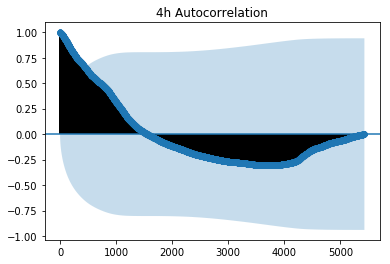

In [7]:
# Plot autocorrelation of close price
# Sample 2015-2018, significance is 400 periods (c. 2 months)
# Sample 2016-2018, significance is 400 periods (c. 2 months)
# Sample 2017/2018, significance is 240 periods (c. 1 month)
# Sample 2015, significance is 100 periods (c. 2 weeks)
# Sample 2016, significance is 160 periods (c. 3 weeks)
# Sample 2017, significance is 140 periods (c. 3 weeks)
# Sample partial-2018, significance is 50 periods (c. 1 week)

from pandas import Series
from statsmodels.graphics.tsaplots import plot_acf
series = df['close']
plot_acf(series,lags=len(series)-1, alpha=0.05, title='4h Autocorrelation')
plt.show();

Price is not random. There are emerging trends over time. The time series is autocorrelated for c. 2 months.

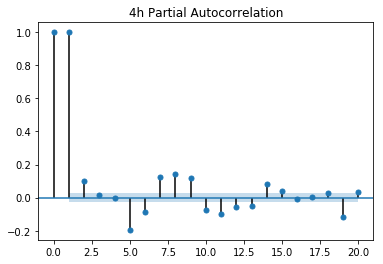

In [8]:
# Plot partial autocorrelation - close price 
# Sample 2017/2018, significance is 2 periods (8 hours)
# Sample 2017, significance is 1 periods (8 hours)
# Sample partial-2018, significance is 2 periods (8 hours)
from statsmodels.graphics.tsaplots import plot_pacf
series = df['close']
plot_pacf(series, lags=20,alpha=0.05, title='4h Partial Autocorrelation')
plt.show()

On the other hand - prices on shorter time scales are largely random after 8 hours has passed

In [9]:
# How many buy periods were there against sell periods
df['target'].value_counts()

buy     3139
sell    2285
Name: target, dtype: int64

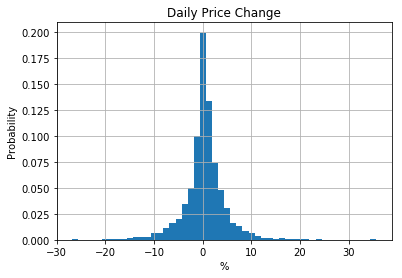

In [10]:
# The spread of daily price changes
x = df['1day_price_change'].dropna()

# the histogram of the data
n, bins, patches = plt.hist(x, 50, normed=1)

plt.xlabel('%')
plt.ylabel('Probability')
plt.title('Daily Price Change')
plt.grid(True)
plt.show()

In [11]:
# Price change from 24h ago
df['prev_1day_price_change'] = (df['close'].shift(6) - df['close'])/(df['close'].shift(6))*100

In [12]:
# RSI appears too choppy to use meaningfully, hence calculating a moving average 6 period RSI
df['rsi_ma6'] = df['rsi'].rolling(window=6).mean()

In [13]:
# Smooth out volume over the day
df['Volume_BTC_ma6'] = df['Volume_BTC'].rolling(window=6).mean()

In [14]:
# Measure how far the closing price is away from the upper and lower bollinger bands
df['bblower_dist']=(df['close']-df['bblower'])/df['bbwidth']
df['bbupper_dist']=(df['bbupper']-df['close'])/df['bbwidth']

In [15]:
# Create a EMA crossover metric
df['emahist'] = df['ema20'] - df['ema50']

In [16]:
df.dropna(inplace=True)
print(df.shape)
df.head()

(5375, 25)


,Timestamp,open,high,low,close,Volume_BTC,rsi,bbupper,bbmiddle,bblower,...,ema50,candle_summary,1day_price_change,target,prev_1day_price_change,rsi_ma6,Volume_BTC_ma6,bblower_dist,bbupper_dist,emahist
1530,2016-01-09 04:00:00,415.00,415.00,411.00,414.87,6.710800,55.731622,418.876179,416.460,414.043821,...,404.974000,0,-1.017186,sell,0.824727,59.862088,73.948794,0.170968,0.829032,8.493083
1531,2016-01-09 08:00:00,413.32,415.13,411.31,414.24,68.240101,54.570058,417.574973,415.620,413.665027,...,405.337373,0,-1.680185,sell,1.253874,58.170844,66.849839,0.147054,0.852946,8.203321
1532,2016-01-09 12:00:00,414.11,414.32,411.26,414.00,57.062590,54.107407,417.586502,415.264,412.941498,...,405.677083,0,-1.369565,sell,1.061084,56.722242,58.256132,0.227880,0.772120,7.907354
1533,2016-01-09 16:00:00,413.61,416.44,412.93,414.94,65.949553,55.691876,416.370808,414.848,413.325192,...,406.040335,0,-0.939895,sell,0.202030,56.314027,41.908230,0.530207,0.469793,7.673203
1534,2016-01-09 20:00:00,414.95,414.98,412.39,412.99,30.950000,51.703870,415.622745,414.208,412.793255,...,406.312871,0,0.033899,buy,0.966381,54.990698,42.474457,0.069534,0.930466,7.331759


<b> POTENTIAL CORRELATIONS WITH FUTURE PRICE

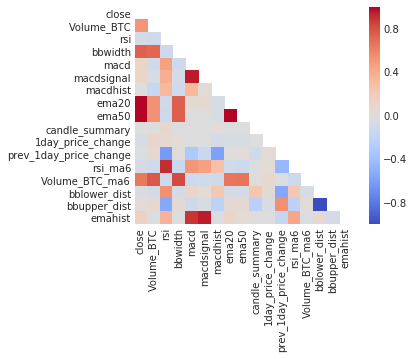

In [17]:
import seaborn as sns
import numpy as np
corr_select = df.loc[:,['close', 'Volume_BTC', 'rsi', 'bbwidth', 'macd', 'macdsignal',
       'macdhist', 'ema20', 'ema50', 'candle_summary', '1day_price_change',
       'target', 'prev_1day_price_change', 'rsi_ma6', 'Volume_BTC_ma6',
       'bblower_dist', 'bbupper_dist','emahist']]

corr = corr_select.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    ax = sns.heatmap(corr, mask=mask,vmin=-1, vmax=1, square=True, cmap="coolwarm")
    
# Close Price is correlated with Volume_BTC_ma6 (and more strongly than just Volume_BTC) - suggests momentum builds over 24h
# Almost nothing seems to be correlated with 1day_price_change (forward looking)
    # Correlation is 10% with volume, 8% with volume MA6, 5% with BBdistance, 4% with RSI MA6

<b> POTENTIAL BUY/SELL CLASSIFIERS

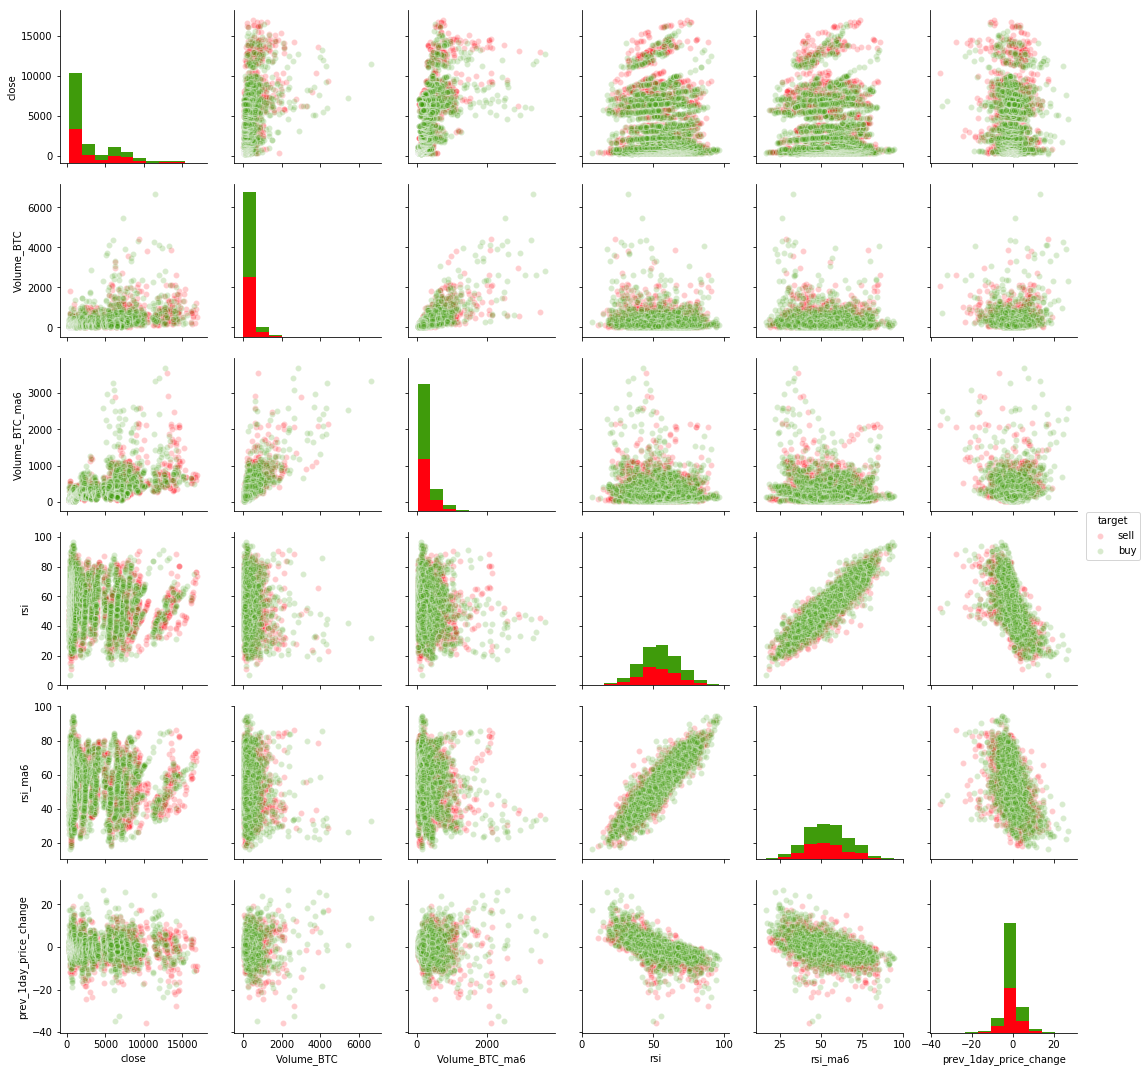

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the color scheme for plots - https://xkcd.com/color/rgb/ (for named colors)
color_list = ["bright red","grass green", "grey"]
sns.palplot(sns.xkcd_palette(color_list))
color_list_palette = sns.xkcd_palette(color_list)
sns.set_palette(color_list_palette)

%matplotlib inline
plot_list1 = ['close','Volume_BTC','Volume_BTC_ma6','rsi','rsi_ma6','prev_1day_price_change' ]
sns.pairplot(df[plot_list1 + ["target"]],
             hue="target",
             plot_kws={"alpha": 0.2});

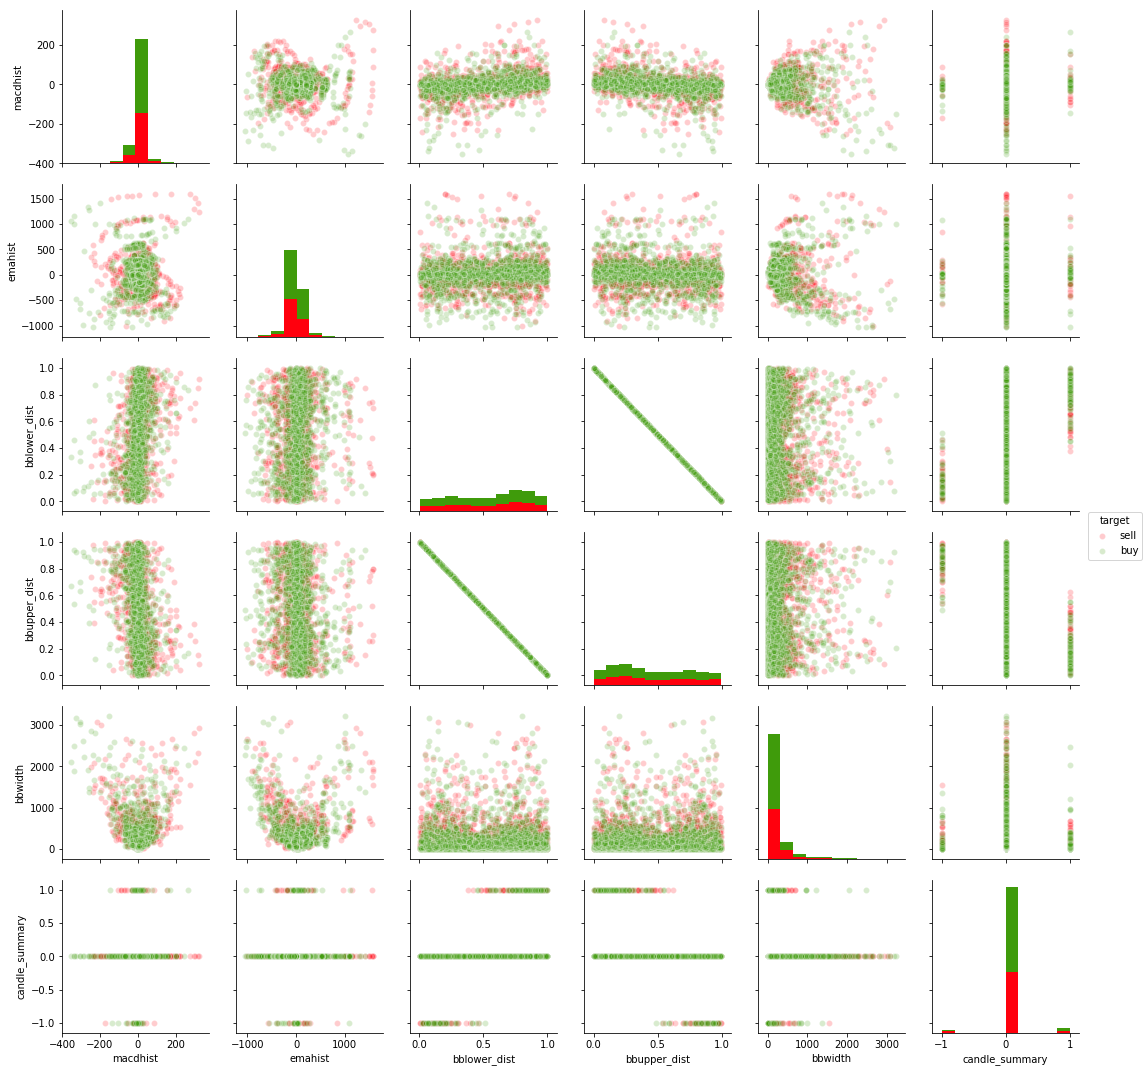

In [19]:
%matplotlib inline
plot_list2 = ['macdhist','emahist','bblower_dist','bbupper_dist','bbwidth','candle_summary']
sns.pairplot(df[plot_list2 + ["target"]],
             hue="target",
             plot_kws={"alpha": 0.2});

In [20]:
# Suggest the following look most interesting: emahist, bblower_dist, bbwidth, macdhist, Volume_BTC_ma6, rsi_ma6
# BUT: Volume_BTC_ma6 is strongly correlated with bbwidth, so ignore bbwidth

<b> PLOT INDICATORS

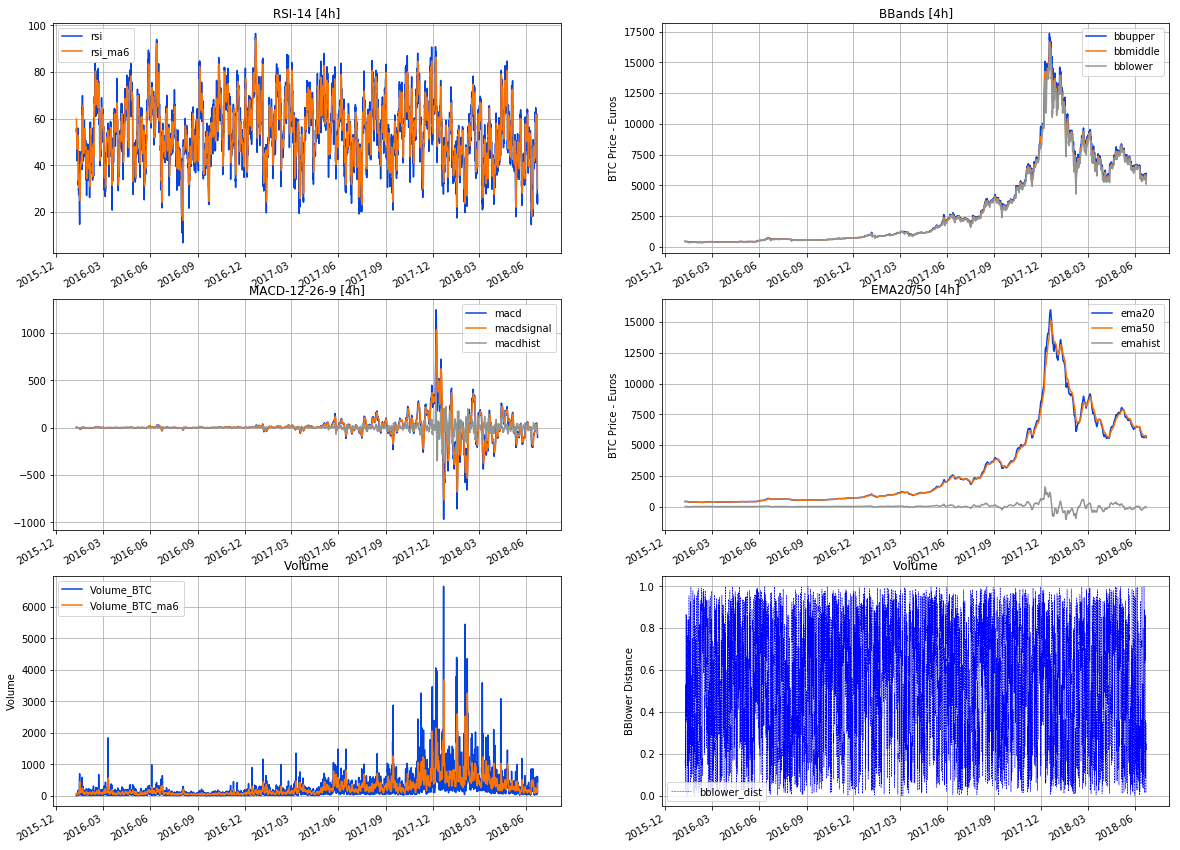

In [21]:
# Plot all results - MAKE SELECTION OF TIMEFRAME

RSI_title = 'RSI-14 [4h]'
BBands_title = 'BBands [4h]'
MACD_title = 'MACD-12-26-9 [4h]'
EMA_title = 'EMA20/50 [4h]'
Vol_title='Volume'
################################################
# Set the color scheme for plots - https://xkcd.com/color/rgb/ (for named colors)
color_list = ["blue","orange", "grey"]
sns.palplot(sns.xkcd_palette(color_list))
color_list_palette = sns.xkcd_palette(color_list)
sns.set_palette(color_list_palette);
%matplotlib inline
################################################
fig, axes = plt.subplots(3,2,figsize=(20,16))
df.plot(x='Timestamp', y='rsi', ax=axes[0][0],grid=True, title=RSI_title);
df.plot(x='Timestamp', y='rsi_ma6', ax=axes[0][0],grid=True, title=RSI_title);
axes[0][0].set_xlabel("")

df.plot(x='Timestamp', y='bbupper',ax=axes[0][1],grid=True, title=BBands_title)
df.plot(x='Timestamp', y='bbmiddle',ax=axes[0][1],grid=True)
df.plot(x='Timestamp', y='bblower',ax=axes[0][1],grid=True)
axes[0][1].set_ylabel("BTC Price - Euros")
axes[0][1].set_xlabel("")

df.plot(x='Timestamp', y='macd',ax=axes[1][0],grid=True, title=MACD_title)
df.plot(x='Timestamp', y='macdsignal',ax=axes[1][0],grid=True)
df.plot(x='Timestamp', y='macdhist',ax=axes[1][0],grid=True)
axes[1][0].set_xlabel("")

df.plot(x='Timestamp', y='ema20',ax=axes[1][1],grid=True, title=EMA_title)
df.plot(x='Timestamp', y='ema50',ax=axes[1][1],grid=True)
df.plot(x='Timestamp', y='emahist',ax=axes[1][1],grid=True)
axes[1][1].set_xlabel("")
axes[1][1].set_ylabel("BTC Price - Euros");

#df.plot(kind=bar,x='Timestamp', y='Volume_BTC',ax=axes[2][0],grid=True, title=Vol_title)
df.plot(x='Timestamp', y='Volume_BTC', ax=axes[2][0], grid=True,title=Vol_title)
df.plot(x='Timestamp', y='Volume_BTC_ma6', ax=axes[2][0], grid=True,title=Vol_title)
axes[2][0].set_xlabel("")
axes[2][0].set_ylabel("Volume");

#df.plot(kind=bar,x='Timestamp', y='Volume_BTC',ax=axes[2][0],grid=True, title=Vol_title)
df.plot(x='Timestamp', y='bblower_dist', ax=axes[2][1], grid=True,title=Vol_title, style='b--', lw=0.5)
axes[2][1].set_xlabel("")
axes[2][1].set_ylabel("BBlower Distance");

# 1.4 Machine Learning Classification

<B> 1.4.1 KNeighborsClassifier

In [22]:
# SPLIT THE DATA INTO TRAINING AND TEST SETS
from sklearn.model_selection import train_test_split

X = df[['emahist', 'bblower_dist', 'macdhist', 'Volume_BTC_ma6', 'rsi_ma6']]
y = df["target"]

# Set target to a numeric value for model
y_binary = y.map({"buy": 1, "sell": 0})

# Include stratify (to adjust class imbalance - not a huge issue in this case)
X_train, X_test, y_train, y_test = train_test_split(X, y_binary, stratify=y, test_size=0.3, random_state=42)

print(len(X_train), len(X_test))

3762 1613


In [23]:
# RUN KNeighborsClassifier MODEL ON TRAINING SET, WITH GRID SEARCH TO OPTIMISE k
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

grid = GridSearchCV(estimator=KNeighborsClassifier(),
                    param_grid={"n_neighbors": [1, 3, 5, 7, 9, 11, 13, 15, 17]},
                    scoring="accuracy",
                    cv=10,
                    return_train_score=True)

grid.fit(X_train, y_train);

In [24]:
# Check variance of training folds to understand how stable model is
scores = grid.cv_results_['mean_test_score']
print(scores, np.mean(scores))

[0.67756512 0.65497076 0.63795853 0.63423711 0.62892079 0.61616162
 0.61483254 0.61137693 0.60499734] 0.6312245259613681


In [25]:
print(f"KNeighborsClassifier, 5 features, k= {grid.best_params_}, best accuracy: {grid.best_score_}")

KNeighborsClassifier, 5 features, k= {'n_neighbors': 1}, best accuracy: 0.677565124933546


In [26]:
# Plot confusion matrix for KNN model with grid optimised paramaters
from sklearn.metrics import confusion_matrix

y_pred_knn = grid.best_estimator_.predict(X_test)

conf_matrix = confusion_matrix(y_test, y_pred_knn)

# Plot a normalized table
cm_knn = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
print(cm_knn)

[[0.57522124 0.42477876]
 [0.27700535 0.72299465]]


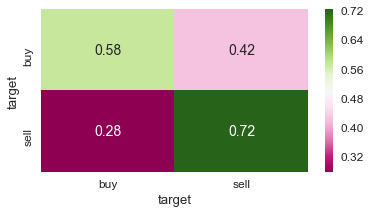

In [27]:
# Visualise the confusion matrix for KNN model with grid search optimised k paramater
array = cm_knn
s = conf_matrix.shape[0]
r = df.groupby('target').agg(['count']).index

df_cm = pd.DataFrame(array, index=r, columns=r)

plt.figure(figsize = (6,3))
sns.set(font_scale=1.2)#for label size
sns.heatmap(df_cm,cmap="PiYG", annot=True,annot_kws={"size": 14});# font size

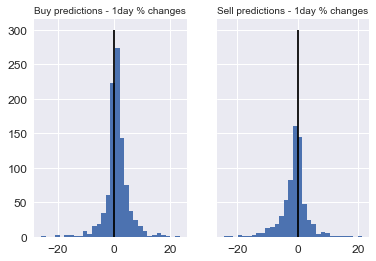

In [28]:
# Add a column to the original dataframe summarising the predictions of the KNN model
df['predicted_target_knn'] = grid.best_estimator_.predict(X)

# Plot the spread of outcomes against predictions
test_set = df.loc[y_test.index,:]
test_set['actual_target'] = test_set["target"].map({'buy':1, 'sell':0})
test_set_predicted_buys = test_set[test_set['predicted_target_knn'] == 1]
test_set_predicted_sells = test_set[test_set['predicted_target_knn'] == 0]

# Histograms
fig, axs = plt.subplots(1, 2, sharey=True)
axs[0].hist(test_set_predicted_buys["1day_price_change"], bins=30)
axs[0].set_title("Buy predictions - 1day % changes", fontsize=10)
axs[0].vlines(x=0, ymin=0.0, ymax=300.0, color='k')
axs[1].hist(test_set_predicted_sells["1day_price_change"], bins=30);
axs[1].set_title("Sell predictions - 1day % changes", fontsize=10)
axs[1].vlines(x=0, ymin=0.0, ymax=300.0, color='k')
plt.show()


<b> 1.4.2 KNeighborsClassifier with StandardScaler

In [34]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
ss = StandardScaler()

X_train_tf = ss.fit_transform(X_train)

# use k=9 from grid search
grid_tf = GridSearchCV(estimator=KNeighborsClassifier(),
                    param_grid={"n_neighbors": [1, 3, 5, 7, 9, 11, 13, 15, 17]},
                    scoring="accuracy",
                    cv=10,
                    return_train_score=True)

grid_tf.fit(X_train_tf, y_train);

In [35]:
# Check variance and stability of model
scores = grid_tf.cv_results_['mean_test_score']
print(scores, np.mean(scores))

[0.59914939 0.60233918 0.5994152  0.59223817 0.59144072 0.59968102
 0.59144072 0.58426369 0.58878256] 0.5943056293933487


In [36]:
print(f"Standardised KNeighborsClassifier, 5 features, k= {grid_tf.best_params_}, best accuracy: {grid_tf.best_score_}")

Standardised KNeighborsClassifier, 5 features, k= {'n_neighbors': 3}, best accuracy: 0.6023391812865497


In [37]:
# Plot confusion matrix for STANDARDISED FEATURE KNN model with grid optimised k paramater
y_pred_knn_tf = grid_tf.best_estimator_.predict(X_test)

conf_matrix = confusion_matrix(y_test, y_pred_knn_tf)

# Plot a normalized table
cm_knn_tf = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
print(cm_knn_tf)

[[0.3879056  0.6120944 ]
 [0.40106952 0.59893048]]


<b> 1.4.3 Decision Tree Classifier

In [38]:
from sklearn.tree import DecisionTreeClassifier

grid_dt = GridSearchCV(estimator=DecisionTreeClassifier(),
                    param_grid={'min_samples_leaf': [3, 4, 5],
                                'max_depth': [None, 1,3,5,7,9,10,11,12,13]
                               },
                    scoring="accuracy",
                    cv=10,
                    return_train_score=True)

grid_dt.fit(X_train, y_train);

In [39]:
# Check stability of model
scores = grid_dt.cv_results_['mean_test_score']
print(scores, np.mean(scores))

[0.60685805 0.60738969 0.60792132 0.57363105 0.57363105 0.57363105
 0.58452951 0.58426369 0.58452951 0.59330144 0.5927698  0.59250399
 0.5994152  0.59994684 0.5994152  0.5994152  0.59861776 0.59968102
 0.60313663 0.59994684 0.60154173 0.61350346 0.61297182 0.61403509
 0.60499734 0.60446571 0.60526316 0.61456672 0.61217438 0.61057948] 0.5989544568491936


In [40]:
print(f"DecisionTreeClassifier, 5 features, params= {grid_dt.best_params_}, best accuracy: {grid_dt.best_score_}")

DecisionTreeClassifier, 5 features, params= {'max_depth': 13, 'min_samples_leaf': 3}, best accuracy: 0.6145667198298778


In [41]:
# Alternatively use the best params from the grid with cross_val_score to see what the best model could be
dt = DecisionTreeClassifier(max_depth=11, min_samples_leaf=4)

scores = cross_val_score(dt, X_train, y_train, scoring="accuracy", cv=10)
print(scores, np.mean(scores));

[0.60212202 0.64456233 0.6356383  0.61702128 0.60638298 0.6356383
 0.55851064 0.6143617  0.59840426 0.64361702] 0.6156258818217732


In [42]:
""" To export a visualisation of the tree - http://www.webgraphviz.com/
from sklearn.tree import export_graphviz

export_graphviz(dt, "bitcoin_4h_buy_sell.dot", feature_names=['emahist', 'bblower_dist', 'macdhist', 'Volume_BTC_ma6', 'rsi_ma6'])
""";

In [43]:
# View most important features
dt.fit(X_train, y_train);

for z in zip(X_train.columns, dt.feature_importances_):
    print(z)

('emahist', 0.30861406988958956)
('bblower_dist', 0.155140332001263)
('macdhist', 0.15272729048545378)
('Volume_BTC_ma6', 0.17121406179314855)
('rsi_ma6', 0.21230424583054508)


In [44]:
# Plot confusion matrix for DECISION TREE model with grid optimised paramaters
y_pred_dt = grid_dt.best_estimator_.predict(X_test)

conf_matrix = confusion_matrix(y_test, y_pred_dt)

# Plot a normalized table
cm_dt = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
print(cm_dt)

[[0.43067847 0.56932153]
 [0.28342246 0.71657754]]


<b> 1.4.4 Random Tree Forest Classifier

In [45]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [50]:
"""# (WARNING 300 combinations takes 16 min!)
# Use the random grid to search for best hyperparameters 
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)
"""

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=30, bootstrap=True 
[CV] n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=30, bootstrap=True 
[CV] n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=30, bootstrap=True 
[CV] n_estimators=2000, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=10, bootstrap=True 
[CV]  n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=30, bootstrap=True, total=   3.8s
[CV] n_estimators=2000, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=10, bootstrap=True 
[CV]  n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=30, bootstrap=True, total=   3.8s
[CV] n_estimators=2000, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=10, bootstrap=True 


[CV] n_estimators=800, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=90, bootstrap=False 
[CV]  n_estimators=1800, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=10, bootstrap=False, total=  19.5s
[CV] n_estimators=2000, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=10, bootstrap=False 


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.9min


[CV]  n_estimators=800, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=90, bootstrap=False, total=  12.6s
[CV] n_estimators=2000, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=10, bootstrap=False 
[CV]  n_estimators=800, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=90, bootstrap=False, total=  12.9s
[CV] n_estimators=2000, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=10, bootstrap=False 
[CV]  n_estimators=800, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=90, bootstrap=False, total=  12.6s
[CV] n_estimators=1600, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=10, bootstrap=False 
[CV]  n_estimators=2000, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=10, bootstrap=False, total=  22.2s
[CV] n_estimators=1600, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=10, bootstrap=False 
[CV]  n_estimators=2

[CV] n_estimators=1800, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=None, bootstrap=True 
[CV]  n_estimators=1600, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=70, bootstrap=False, total=  22.3s
[CV] n_estimators=1800, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=None, bootstrap=True 
[CV]  n_estimators=1400, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=80, bootstrap=True, total=  11.9s
[CV] n_estimators=1400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=80, bootstrap=False 
[CV]  n_estimators=1800, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=None, bootstrap=True, total=  16.5s
[CV] n_estimators=1400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=80, bootstrap=False 
[CV]  n_estimators=1800, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=None, bootstrap=True, total=  16.9s
[CV] n_estimators

[CV]  n_estimators=800, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=100, bootstrap=False, total=  10.7s
[CV] n_estimators=1800, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=90, bootstrap=True 
[CV]  n_estimators=800, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=50, bootstrap=True, total=   6.8s
[CV] n_estimators=800, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=20, bootstrap=False 
[CV]  n_estimators=800, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=20, bootstrap=False, total=  10.1s
[CV] n_estimators=800, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=20, bootstrap=False 
[CV]  n_estimators=1800, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=90, bootstrap=True, total=  15.3s
[CV] n_estimators=800, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=20, bootstrap=False 
[CV]  n_estimators=1800

[CV]  n_estimators=200, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=90, bootstrap=False, total=   2.7s
[CV] n_estimators=2000, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=90, bootstrap=True 
[CV]  n_estimators=1000, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=110, bootstrap=True, total=   9.4s
[CV] n_estimators=2000, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=90, bootstrap=True 
[CV]  n_estimators=1000, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=110, bootstrap=True, total=   9.2s
[CV] n_estimators=2000, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=90, bootstrap=True 
[CV]  n_estimators=1000, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=110, bootstrap=True, total=   9.6s
[CV] n_estimators=400, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=80, bootstrap=False 
[CV]  n_estimators=400, 

[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  8.6min


[CV]  n_estimators=1000, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=50, bootstrap=False, total=  13.2s
[CV] n_estimators=1000, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=50, bootstrap=False 
[CV]  n_estimators=1000, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=50, bootstrap=False, total=  13.2s
[CV] n_estimators=1000, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=30, bootstrap=False 
[CV]  n_estimators=2000, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=50, bootstrap=False, total=  28.4s
[CV] n_estimators=1000, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=30, bootstrap=False 
[CV]  n_estimators=2000, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=50, bootstrap=False, total=  26.9s
[CV] n_estimators=1000, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=30, bootstrap=False 
[CV]  n_estimat

[CV] n_estimators=1200, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=None, bootstrap=False 
[CV]  n_estimators=1000, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=80, bootstrap=False, total=  13.2s
[CV] n_estimators=1600, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=20, bootstrap=True 
[CV]  n_estimators=1200, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=None, bootstrap=False, total=  16.2s
[CV] n_estimators=1600, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=20, bootstrap=True 
[CV]  n_estimators=1600, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=20, bootstrap=True, total=  14.1s
[CV] n_estimators=1600, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=20, bootstrap=True 
[CV]  n_estimators=1200, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=None, bootstrap=False, total=  16.3s
[CV] n_est

[CV]  n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=90, bootstrap=False, total=   5.6s
[CV] n_estimators=400, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=90, bootstrap=False 
[CV]  n_estimators=400, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=90, bootstrap=False, total=   5.3s
[CV] n_estimators=400, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=90, bootstrap=False 
[CV]  n_estimators=1600, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=90, bootstrap=True, total=  15.2s
[CV] n_estimators=400, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=90, bootstrap=False 
[CV]  n_estimators=400, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=90, bootstrap=False, total=   5.4s
[CV] n_estimators=1600, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=None, bootstrap=True 
[CV]  n_estimators=1

[CV] n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=100, bootstrap=True 
[CV]  n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=100, bootstrap=True, total=   3.8s
[CV] n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=100, bootstrap=True 
[CV]  n_estimators=600, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=40, bootstrap=False, total=   8.3s
[CV] n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=100, bootstrap=True 
[CV]  n_estimators=600, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=40, bootstrap=False, total=   8.3s
[CV] n_estimators=1600, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=80, bootstrap=True 
[CV]  n_estimators=600, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=40, bootstrap=False, total=   8.1s
[CV] n_estimators=1600, m

[CV] n_estimators=200, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=100, bootstrap=False 
[CV]  n_estimators=200, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=100, bootstrap=False, total=   3.0s
[CV] n_estimators=200, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=100, bootstrap=False 
[CV]  n_estimators=1000, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=10, bootstrap=False, total=  12.1s
[CV] n_estimators=2000, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=20, bootstrap=True 
[CV]  n_estimators=1000, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=10, bootstrap=False, total=  11.8s
[CV] n_estimators=2000, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=20, bootstrap=True 
[CV]  n_estimators=200, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=100, bootstrap=False, total=   3.1s
[CV] n_estimators=2000

[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 16.5min finished


RandomizedSearchCV(cv=3, error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid=True, n_iter=100, n_jobs=-1,
          param_distributions={'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

In [46]:
# rf_random.best_params_
rf_random_best_params = {'bootstrap': False,
 'max_depth': 40,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 1400}

# rf_random.best_score_
rf_random_best_score = 0.662147793726741

In [47]:
print(f"RandomForestClassifier with RandomizedSearchCV, 5 features, best accuracy: {rf_random_best_score}")

RandomForestClassifier with RandomizedSearchCV, 5 features, best accuracy: 0.662147793726741


In [58]:
""" WARNING 405 fits takes 50min
# Fine tune the results based on best randomised results above with GridSearchCV

param_grid = {
    'bootstrap': [False],
    'max_depth': [30, 40, 50],
    'max_features': ['auto'],
    'min_samples_leaf': [1, 2, 3],
    'min_samples_split': [2, 4, 8],
    'n_estimators': [1000, 1200, 1400, 1600, 1800]}

grid_rf = GridSearchCV(estimator=RandomForestClassifier(),
                    param_grid=param_grid,
                    scoring="accuracy",
                    cv=3,
                    n_jobs = -1,
                    verbose = 2,
                    return_train_score=True)

grid_rf.fit(X_train, y_train);
"""

Fitting 3 folds for each of 135 candidates, totalling 405 fits
[CV] bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=1000 
[CV] bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=1000 
[CV] bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=1000 
[CV] bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=1200 
[CV]  bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=1000, total=  15.1s
[CV] bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=1200 
[CV]  bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=1000, total=  15.5s
[CV] bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_esti

[CV] bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=8, n_estimators=1200 
[CV]  bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=8, n_estimators=1000, total=  13.5s
[CV] bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=8, n_estimators=1400 


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  2.9min


[CV]  bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=8, n_estimators=1200, total=  16.6s
[CV] bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=8, n_estimators=1400 
[CV]  bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=8, n_estimators=1200, total=  16.8s
[CV] bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=8, n_estimators=1400 
[CV]  bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=8, n_estimators=1200, total=  15.9s
[CV] bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=8, n_estimators=1600 
[CV]  bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=8, n_estimators=1400, total=  19.3s
[CV] bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=8, n_estimators=1600 
[CV]  bootstrap=Fals

[CV] bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=1600 
[CV]  bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=1400, total=  20.0s
[CV] bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=1600 
[CV]  bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=1400, total=  19.6s
[CV] bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=1800 
[CV]  bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=1600, total=  22.7s
[CV] bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=1800 
[CV]  bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=1600, total=  23.2s
[CV] bootstrap=False

[CV]  bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=1600, total=  21.1s
[CV] bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=1800 
[CV]  bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=1600, total=  20.3s
[CV] bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=3, min_samples_split=4, n_estimators=1000 
[CV]  bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=1800, total=  23.4s
[CV] bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=3, min_samples_split=4, n_estimators=1000 
[CV]  bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=3, min_samples_split=4, n_estimators=1000, total=  12.9s
[CV] bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=3, min_samples_split=4, n_estimators=1000 
[CV]  bootstrap=Fals

[CV] bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=1000 
[CV]  bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=1000, total=  14.3s
[CV] bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=1200 
[CV]  bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=3, min_samples_split=8, n_estimators=1800, total=  23.4s
[CV] bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=1200 
[CV]  bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=1000, total=  14.6s
[CV] bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=1200 
[CV]  bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=1000, total=  13.8s
[CV] bootstrap=False

[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 12.9min


[CV]  bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=1200, total=  16.6s
[CV] bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=1400 
[CV]  bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=1200, total=  16.1s
[CV] bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=1600 
[CV]  bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=1400, total=  19.3s
[CV] bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=1600 
[CV]  bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=1400, total=  19.6s
[CV] bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=1600 
[CV]  bootstrap=Fals

[CV] bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=1600 
[CV]  bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=1400, total=  18.7s
[CV] bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=1800 
[CV]  bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=1600, total=  21.9s
[CV] bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=1800 
[CV]  bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=1600, total=  22.0s
[CV] bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=1800 
[CV]  bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=1600, total=  21.3s
[CV] bootstrap=False

[CV]  bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=1600, total=  21.9s
[CV] bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=1000 
[CV]  bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=1800, total=  25.1s
[CV] bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=1000 
[CV]  bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=1000, total=  13.5s
[CV] bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=1000 
[CV]  bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=1800, total=  25.0s
[CV] bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=1200 
[CV]  bootstrap=Fals

[CV] bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=3, min_samples_split=8, n_estimators=1200 
[CV]  bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=3, min_samples_split=4, n_estimators=1800, total=  24.4s
[CV] bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=3, min_samples_split=8, n_estimators=1200 
[CV]  bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=3, min_samples_split=8, n_estimators=1000, total=  14.2s
[CV] bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=3, min_samples_split=8, n_estimators=1200 
[CV]  bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=3, min_samples_split=8, n_estimators=1000, total=  14.2s
[CV] bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=3, min_samples_split=8, n_estimators=1400 
[CV]  bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=3, min_samples_split=8, n_estimators=1200, total=  17.3s
[CV] bootstrap=False

[CV]  bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=1200, total=  18.7s
[CV] bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=1400 
[CV]  bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=1200, total=  17.7s
[CV] bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=1400 
[CV]  bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=1200, total=  18.5s
[CV] bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=1600 
[CV]  bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=1400, total=  21.2s
[CV] bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=1600 
[CV]  bootstrap=Fals

[CV] bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=1600 
[CV]  bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=1400, total=  19.1s
[CV] bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=1600 
[CV]  bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=1400, total=  18.8s
[CV] bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=1800 
[CV]  bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=1600, total=  21.8s
[CV] bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=1800 
[CV]  bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=1600, total=  21.8s
[CV] bootstrap=False

[CV]  bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=1600, total=  21.4s
[CV] bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=1800 
[CV]  bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=1600, total=  20.5s
[CV] bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=1000 


[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed: 45.8min


[CV]  bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=1800, total=  23.6s
[CV] bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=1000 
[CV]  bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=1000, total=  13.0s
[CV] bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=1000 
[CV]  bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=1800, total=  24.0s
[CV] bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=1200 
[CV]  bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=8, n_estimators=1800, total=  23.2s
[CV] bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=1200 
[CV]  bootstrap=Fals

[CV] bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=3, min_samples_split=8, n_estimators=1200 
[CV]  bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=3, min_samples_split=8, n_estimators=1000, total=  13.4s
[CV] bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=3, min_samples_split=8, n_estimators=1200 
[CV]  bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=3, min_samples_split=8, n_estimators=1000, total=  13.1s
[CV] bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=3, min_samples_split=8, n_estimators=1400 
[CV]  bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=3, min_samples_split=8, n_estimators=1200, total=  16.1s
[CV] bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=3, min_samples_split=8, n_estimators=1400 
[CV]  bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=3, min_samples_split=8, n_estimators=1200, total=  16.2s
[CV] bootstrap=False

[Parallel(n_jobs=-1)]: Done 405 out of 405 | elapsed: 49.9min finished


In [48]:
# grid_rf.best_params_
grid_rf_best_params = {'bootstrap': False,
 'max_depth': 30,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 1600}

# grid_rf.best_score_
grid_rf_best_core = 0.6624136097820308

In [49]:
# Check stability of Random Forest model with Random and Grid optimised paramters
# scores = grid_rf.cv_results_['mean_test_score']
# print(scores, np.mean(scores))
scores = [0.65842637, 0.66188198, 0.658958,   0.66241361, 0.65948963, 0.65550239,
 0.65683147, 0.65922382, 0.65709729, 0.658958,   0.65311005, 0.65443913,
 0.65470494, 0.65204678, 0.65337586, 0.65576821, 0.65656566, 0.65550239,
 0.65842637, 0.65550239, 0.65842637, 0.6573631,  0.65470494, 0.65762892,
 0.66002127, 0.64885699, 0.64938862, 0.65124934, 0.65124934, 0.65204678,
 0.64912281, 0.65204678, 0.64938862, 0.65178097, 0.65124934, 0.65178097,
 0.65045189, 0.64938862, 0.65098352, 0.6573631,  0.65045189, 0.65311005,
 0.65018607, 0.6507177,  0.6507177,  0.66161616, 0.66135035, 0.66241361,
 0.66188198, 0.66135035, 0.65975545, 0.65683147, 0.6605529,  0.66081871,
 0.65869219, 0.65417331, 0.65550239, 0.65204678, 0.65364168, 0.65311005,
 0.65311005, 0.65470494, 0.65443913, 0.65869219, 0.65842637, 0.658958,
 0.65629984, 0.6573631,  0.65656566, 0.65523658, 0.65204678, 0.65364168,
 0.65204678, 0.6523126,  0.65364168, 0.65204678, 0.64992026, 0.65124934,
 0.65098352, 0.64965444, 0.6539075,  0.65204678, 0.65124934, 0.65045189,
 0.65151515, 0.64699628, 0.64938862, 0.65151515, 0.64965444, 0.65018607,
 0.65975545, 0.65922382, 0.66214779, 0.66081871, 0.658958,   0.65762892,
 0.658958,   0.658958,   0.6573631,  0.66028708, 0.6523126,  0.65284423,
 0.65417331, 0.65550239, 0.65124934, 0.65497076, 0.66028708, 0.65869219,
 0.65629984, 0.65709729, 0.65550239, 0.65470494, 0.65470494, 0.65629984,
 0.65470494, 0.65257842, 0.65151515, 0.65337586, 0.65470494, 0.65178097,
 0.65045189, 0.65576821, 0.65257842, 0.65151515, 0.64885699, 0.64965444,
 0.65151515, 0.6507177,  0.64965444, 0.6523126,  0.64859117, 0.65045189,
 0.65124934, 0.65045189, 0.64832536]
scores_mean = 0.6545139504203831

In [50]:
print(f"RandomForestClassifier, 5 features, params=randomsearch & grid, best accuracy: {grid_rf_best_core}")

RandomForestClassifier, 5 features, params=randomsearch & grid, best accuracy: 0.6624136097820308


In [51]:
# For quick reproducability, manually input optimised RF parameters, then plot confusion matrix 
# y_pred_grid_rf = grid_rf.best_estimator_.predict(X_test)
grid_rf = RandomForestClassifier(bootstrap= False,max_depth= 30,max_features= 'auto',min_samples_leaf= 1,min_samples_split= 2,n_estimators= 1600)

grid_rf.fit(X_train, y_train);

y_pred_grid_rf = grid_rf.predict(X_test)

conf_matrix = confusion_matrix(y_test, y_pred_grid_rf)

# Plot a normalized table
cm_grid_rf = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
print(cm_grid_rf)

[[0.53097345 0.46902655]
 [0.19786096 0.80213904]]


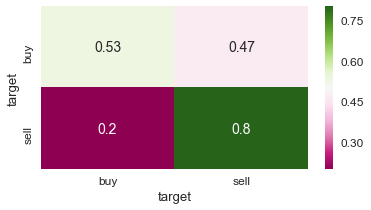

In [52]:
# Visualise the confusion matrix 
array = cm_grid_rf
s = conf_matrix.shape[0]
r = df.groupby('target').agg(['count']).index

df_cm = pd.DataFrame(array, index=r, columns=r)

plt.figure(figsize = (6,3))
sns.set(font_scale=1.2)#for label size
sns.heatmap(df_cm,cmap="PiYG", annot=True,annot_kws={"size": 14});# font size

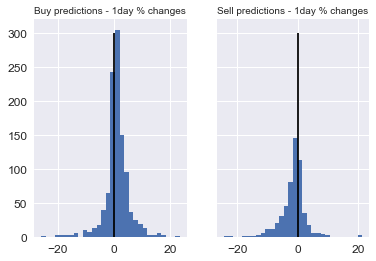

In [54]:
# Add a column to the original dataframe summarising the predictions of the RF model
df['predicted_target_rf'] = grid_rf.predict(X)

# Plot the spread of outcomes against predictions
test_set = df.loc[y_test.index,:]
test_set['actual_target'] = test_set["target"].map({'buy':1, 'sell':0})
test_set_predicted_buys = test_set[test_set['predicted_target_rf'] == 1]
test_set_predicted_sells = test_set[test_set['predicted_target_rf'] == 0]

# Histograms
fig, axs = plt.subplots(1, 2, sharey=True)
axs[0].hist(test_set_predicted_buys["1day_price_change"], bins=30)
axs[0].set_title("Buy predictions - 1day % changes", fontsize=10)
axs[0].vlines(x=0, ymin=0.0, ymax=300.0, color='k')
axs[1].hist(test_set_predicted_sells["1day_price_change"], bins=30);
axs[1].set_title("Sell predictions - 1day % changes", fontsize=10)
axs[1].vlines(x=0, ymin=0.0, ymax=300.0, color='k')
plt.show()

In [56]:
df.to_csv('btc_eur_ohlc_4h_predictive.csv')